# Coding of TD($\lambda$) learner algorithm

In [1]:
from platform import python_version
python_version()

'3.7.4'

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Based on Chapter 12: Eligibility Traces from Sutton & Barto

### TD($\lambda$)

<IMG SRC="images/tdlambda.png">

### Example 7.1 Random walk

In [3]:
from randomwalk import RandomWalkGame

In [4]:
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

In [5]:
game.show_state()

T1 _ _ _ _ _ _ _ _ _ J _ _ _ _ _ _ _ _ _ T2


In [6]:
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ _ _ _ _ _ _ K _ _ _ _ _ _ _ _ T2


In [7]:
game.get_rewards()

{1: 0.0}

## Objective

For verification purposes, we want to replicate the results below which should match Figure 12.8 from the book which looks like this:

<IMG SRC="images/fig_12_8.png">    

## N-Step TD Update - for comparison

In [8]:
def discounted_sequence_generator(sequence, gamma):
    """Returns a generator that yields each item of sequence
    discounted by gamma at each time-step.
    
    Example:
    >>> list(discounted_sequence_generator([10.0]*5, 0.75))
    [10.0, 7.5, 5.625, 4.21875, 3.1640625]
    """
    
    x = 1.0
    for item in sequence:
        yield x*item
        x = x*gamma


def td_n_step_update(value_function, prev_states, prev_rewards, tau, gamma,
                     learning_rate, t_max=np.inf, show=False):
    """Updates the value in value_function for the past state
    that occurred in timestep tau using the n-step TD
    algorithm.
    
    Note:
    tau = t - n + 1

    Where:
        t is the current timestep
        n is the lambda value  

    If tau < 0 no update is possible so none is made.

    Args:
        value_function (dict): Dictionary of state values.
        prev_states (list): List of previous states.
        prev_rewards (list): List of previous rewards.
        tau (int): The timestep of the state that will have
            its value updated.
        gamma (float): Discount rate.
        t_max (int or np.inf): The maximum timestep to include.  
            Set to np.inf or a high number if you want to
            include all timesteps from tau to tau + n.  Set
            to t if the game has eneded.
    """

    assert len(prev_states) == len(prev_rewards)

    if tau >= 0:

        assert tau < len(prev_states), "Not enough past states."

        discounted_rewards = discounted_sequence_generator(
            prev_rewards[tau+1:min(tau + n, t_max) + 1], 
            gamma
        )
        g = sum(list(discounted_rewards))

        if tau + n < t_max:
            g += gamma**n * value_function[prev_states[tau + n]]

        # Update value of state at timestep tau
        state_key = prev_states[tau]
        state_value = value_function[state_key]

        if show:
            print(f"prev_states[{tau}]: {state_value}")

        value_function[state_key] = state_value + \
            learning_rate * (g - state_value)

        if show:
            print(f"value_function[{state_key.__repr__()}]: {value_function[state_key]}")


## TD($\lambda$)

In [9]:
def td_lambda_weight_update(weights, current_state_value, prev_state_value, reward, 
                            dv_dw, z, lam, gamma, learning_rate):
    """Updates the weights of a value function for the 
    previous state using the TD-Lambda algorithm.
    
    Args:
        weights (np.ndarray): Array of weights (value function 
            parameters).
        current_state_value (float): Value estimate for current state.
        prev_state_value (float): Value estimate for previous state.
        reward (float): Reward at current state.
        dv_dw (np.ndarray): Partial derivatives of value function
            w.r.t. the weights at current state.
        z (array): Eligibility trace vector.
        gamma (float): Discount factor.
    """

    assert dv_dw.shape == z.shape
    z = gamma * lam * z + dv_dw
    td_error = reward + gamma * current_state_value - prev_state_value
    
    return weights + learning_rate * td_error * z


## Value Approximation Functions for use with TD-$\lambda$

In [10]:
from abc import ABC, abstractmethod

class FunctionApproximator(ABC):

    def __init__(self, input_shape, d, output_shape=(1,),
                 init_value=0):
        
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.d = d
        self._weights = np.full(d, init_value)

    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, values):
        self._weights[:] = values

    @abstractmethod
    def __call__(self, x):
        """Returns the function estimate at x. x may
        be a single point or sequence of points.
        """
        raise NotImplementedError
    
    @abstractmethod
    def dw(self, x):
        """Returns the partial derivatives w.r.t. the weights
        (parameters) at x.
        """
        raise NotImplementedError


class ValueFunctionDiscreteStates(FunctionApproximator):
    """Uses the following simple linear functon to approximate
    the state-values of an environment:
    
    v_hat = w_0 + w_1 * x
    
    where x is a scalar input feature that is generated from
    the environment's state assuming all the state values are
    a one-dimensional discretized representation of a linear
    state-space.
    """

    def __init__(self, states, terminal_states=None, init_value=0):
        
        if terminal_states is None:
            terminal_states = []
            self.states = states
        else:
            self.states = [s for s in states if s not in terminal_states]
        self.terminal_states = terminal_states
        self.x = np.full(len(self.states), np.nan)
        self.d = len(self.states)
        input_shape = (1, )
        super().__init__(input_shape, self.d, output_shape=(1,), init_value=init_value)
        self.z = np.full_like(self.weights, 0.)

    def __call__(self, state):
        """Returns the value estimate for the given state.
        """
        if state in game.terminal_states:
            return 0.
        x = self.input_mapping(state)
        return np.sum(self.weights * x)
    
    def input_mapping(self, state):
        self.x[:] = 0
        self.x[self.states.index(state)] = 1
        return self.x
    
    def dw(self, state):
        """Returns the partial derivatives of the value 
        function w.r.t. the weights (parameters) at the
        given state.
        """
        if state in game.terminal_states:
            # TODO: Is this the correct thing to do?
            self.x[:] = 0
            x = self.x
        else:
            x = self.input_mapping(state)
        return x

    def update_weights(self, current_state, prev_state, reward,
                       lam, gamma, learning_rate):
        
        self.weights[:] = td_lambda_weight_update(
            self.weights, 
            current_state_value=self(current_state), 
            prev_state_value=self(prev_state), 
            reward=reward,
            dv_dw=self.dw(prev_state),
            z=self.z,
            lam=lam,
            gamma=gamma,
            learning_rate=learning_rate
        )


class ValueFunctionDiscreteStatesLinearApproximator(FunctionApproximator):
    """Uses the following simple linear functon to approximate
    the state-values of an environment:
    
    v_hat = w_0 + w_1 * x
    
    where x is a scalar input feature that is generated from
    the environment's state assuming all the state values are
    a one-dimensional discretized representation of a linear
    state-space.
    """
    
    def __init__(self, states):
        self.states = states
        self.n_states = len(self.states)
        self.terminal_states = [s for s in game.terminal_states]
        self.weights = np.zeros(2)  # Linear function approximator
        self.z = np.full_like(self.weights, 0)  # Eligibility trace vector

    def input_mapper(self, state_key):
        """Converts a discrete state into a (scalar) feature 
        value assuming all the state values represent a one-
        dimensional linear state-space.
        
        returns:
            x (float): (0 <= x <= 1).
        """
        return self.states.index(state_key) / (self.n_states - 1)
    
    def __getitem__(self, key):
        """Return values based on state key (or sequence of keys).
        """
        
        if isinstance(key, str):
            return self.value(key)
        if not isinstance(key, np.ndarray):
            # Convert a simple index x[y] to an array
            key = np.array(key)

        # Handle the different dimensional cases
        return np.fromiter((self.value(xi) for xi in key), key.dtype)
        
    def value(self, state_key):
        """Returns estimate of value of state.
        """
        if state_key in self.terminal_states:
            return 0
        x = self.map_inputs(state_key)
        return self.weights[0] + self.weights[1] * x

    def dw(self, state_key):
        """Partial derivatives of value function w.r.t.
        weights at given state.
        """
        if state_key in self.terminal_states:
            return np.array([1.0, 0.0])
        x = self.map_inputs(state_key)
        return np.array([1.0, x])


In [11]:
# Test ValueFunctionDiscreteStates class
states = game.states
terminal_states = game.terminal_states
value_function = ValueFunctionDiscreteStates(states, terminal_states, 
                                             init_value=0.5)

assert len(value_function.states) == 19
assert value_function.terminal_states == ['T1', 'T2']
assert value_function.d == 19
assert value_function.input_shape == (1,)
assert value_function.weights.shape == (19,)
assert value_function.z.shape == (19,)
assert value_function.x.shape == (19,)
assert np.all(value_function.weights == 0.5)
assert np.all(value_function.z == 0)
assert all([value_function(s) == 0.5 for s in value_function.states])
assert all([value_function(s) == 0.0 for s in 
            value_function.terminal_states])
assert np.array_equal(
    value_function.dw('D'),
    np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)
value_function.weights = [0]*19
assert np.array_equal(
    value_function.weights,
    np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)
current_state = 'K'
prev_state = 'J'
reward = 1
lam = 0.5
gamma = 1.0
learning_rate = 0.1
value_function.update_weights(current_state, prev_state, reward,
                              lam, gamma, learning_rate)

In [12]:
assert np.array_equal(
    value_function.weights,
    np.array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 
              0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])
)
prev_state = current_state
current_state = 'L'
reward = 1
lam = 0.5
gamma = 1.0
learning_rate = 0.1
value_function.update_weights(current_state, prev_state, reward,
                              lam, gamma, learning_rate)
assert np.isclose(
    value_function.weights,
    np.array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 
              0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])
).all()

# Test 1 - Single Episode / Walk Right

## (a) N-Step TD Updates

In [15]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    print(f"{prev_states[-1]} -> {game.state}, {reward}")

    state_key = game.generate_state_key(game.state, role)
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        tau = t - n + 1
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, learning_rate)

    # Update timestep
    t += 1

assert game.game_over

# Complete final state-value updates for timesteps tau
# to current (terminal) timestep
for tau in range(t - n, t):
    td_n_step_update(value_function, prev_states, prev_rewards, 
                     tau, gamma, learning_rate, t_max=t)

# Value function after 1 episode
pd.Series(value_function)

J -> K, 0.0
K -> L, 0.0
L -> M, 0.0
M -> N, 0.0
N -> O, 0.0
O -> P, 0.0
P -> Q, 0.0
Q -> R, 0.0
R -> S, 0.0
S -> T2, 1.0


T1    0.0
A     0.0
B     0.0
C     0.0
D     0.0
E     0.0
F     0.0
G     0.0
H     0.0
I     0.0
J     0.1
K     0.1
L     0.1
M     0.1
N     0.1
O     0.1
P     0.1
Q     0.1
R     0.1
S     0.1
T2    0.0
dtype: float64

## (b) TD($\lambda$)

In [22]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 0.5
value_function = ValueFunctionDiscreteStates(game.states, 
                                             game.terminal_states, 
                                             init_value=0.0)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_state = game.generate_state_key(game.start_state, role)
prev_reward = None
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]
    
    current_state = game.generate_state_key(game.state, role)
    current_state_value = value_function(current_state)

    print(f"{prev_state} -> {current_state}, {reward}")

    # Update the value function weights
    value_function.update_weights(current_state, prev_state, reward,
                                  lam, gamma, learning_rate)

    prev_state = current_state
    prev_reward = reward

    # Update timestep
    t += 1

# Value function after 1 episode
values = {state: value_function(state) for state in game.states}
pd.Series(values)

J -> K, 0.0
K -> L, 0.0
L -> M, 0.0
M -> N, 0.0
N -> O, 0.0
O -> P, 0.0
P -> Q, 0.0
Q -> R, 0.0
R -> S, 0.0
S -> T2, 1.0


T1    0.0
A     0.0
B     0.0
C     0.0
D     0.0
E     0.0
F     0.0
G     0.0
H     0.0
I     0.0
J     0.0
K     0.0
L     0.0
M     0.0
N     0.0
O     0.0
P     0.0
Q     0.0
R     0.0
S     0.1
T2    0.0
dtype: float64

## (c) TD($\lambda$) With Simple Linear Approximation of State

In [44]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 0.5
value_function = ValueApproxFunction(game)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    state_key = game.generate_state_key(game.state, role)
    prev_state = prev_states[-1]
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        td_lambda_update(value_function, prev_state, state_key, 
                         reward, t, lam, gamma)

    # Update timestep
    t += 1

assert game.game_over

# Complete state-value update for final timestep (to terminal state)
td_lambda_update(value_function, prev_state, state_key, reward, t, lam, gamma)

# Value function after 1 episode
values = {state: value_function.value(state) for state in game.states}
pd.Series(values)

NameError: name 'ValueApproxFunction' is not defined

# Test 2 - 10 Episodes Alternating Right, Left, Right, ... etc.

## (a) N-Step TD Updates

In [26]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]
        if reward != 0:
            print(f"{prev_state} -> {current_state}, {reward}")

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma, learning_rate)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, learning_rate, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

T1    0.00000
A    -0.40951
B    -0.40951
C    -0.40951
D    -0.40951
E    -0.40951
F    -0.40951
G    -0.40951
H    -0.40951
I    -0.40951
J    -0.03428
K     0.40951
L     0.40951
M     0.40951
N     0.40951
O     0.40951
P     0.40951
Q     0.40951
R     0.40951
S     0.40951
T2    0.00000
dtype: float64


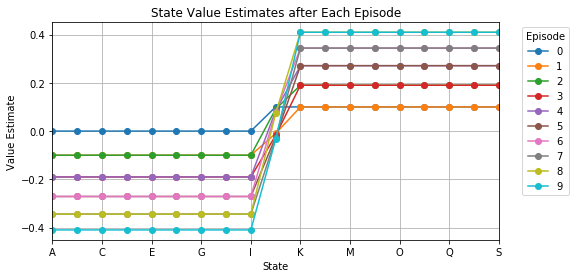

In [27]:
def plot_value_estimates(saved_values):
    terminal_states = game.terminal_states
    combined_results = pd.concat(saved_values, axis=1).drop(terminal_states)
    combined_results.plot(style='o-', figsize=(8,4))
    plt.grid()
    plt.xlabel('State')
    plt.ylabel('Value Estimate')
    plt.title('State Value Estimates after Each Episode')
    plt.legend(title='Episode', bbox_to_anchor=(1.04,1), 
               loc="upper left")
    plt.show()

plot_value_estimates(saved_values)

## (b) TD(λ)

In [42]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 1.0
value_function = ValueFunctionDiscreteStates(game.states, 
                                             game.terminal_states, 
                                             init_value=0.0)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_state = game.generate_state_key(game.start_state, role)
    prev_reward = None
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        current_state = game.generate_state_key(game.state, role)
        current_state_value = value_function(current_state)
        if reward != 0:
            print(f"{prev_state} -> {current_state}, {reward}")

        # Update the value function weights
        value_function.update_weights(current_state, prev_state, reward,
                                      lam, gamma, learning_rate)

        prev_state = current_state
        prev_reward = reward

        # Update timestep
        t += 1
    
    values = {state: value_function(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
pd.Series(values)

S -> T2, 1.0
A -> T1, -1.0
S -> T2, 1.0
A -> T1, -1.0
S -> T2, 1.0
A -> T1, -1.0
S -> T2, 1.0
A -> T1, -1.0
S -> T2, 1.0
A -> T1, -1.0


T1    0.00000
A    -0.40951
B    -0.08146
C    -0.00856
D    -0.00046
E    -0.00001
F     0.00000
G     0.00000
H     0.00000
I     0.00000
J     0.00000
K     0.00000
L     0.00000
M     0.00000
N     0.00000
O     0.00001
P     0.00046
Q     0.00856
R     0.08146
S     0.40951
T2    0.00000
dtype: float64

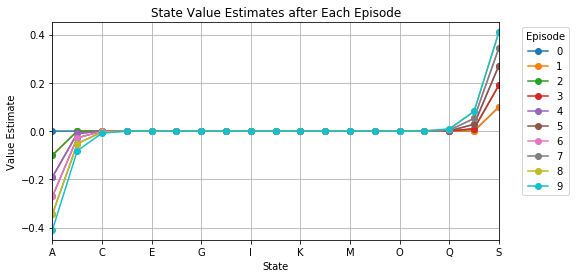

In [43]:
plot_value_estimates(saved_values)

## (c) TD($\lambda$) With Linear Input Map

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
#actions = ['r']*10
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

In [ ]:
plot_value_estimates(saved_values)

# Test 3 - 10 Episodes with Random Walk

## (a) N-Step TD Updates

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

In [ ]:
plot_value_estimates(saved_values)

## (b) TD($\lambda$) With Linear Input Map

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

In [ ]:
plot_value_estimates(saved_values)